In [3]:
# Importing libraries for data manipulation
import pandas as pd
import numpy as np

#Importing libraries for visualization
import matplotlib.pylab as plt
import seaborn as sns

#Importing library for date manipulation
from datetime import datetime

#To calculate the MSE or RMSE
from sklearn.metrics import mean_squared_error

#Importing acf and pacf functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Importing models from statsmodels library
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

#To ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_excel('MER_T12_06.xlsx')
df.head()

,MSN,YYYYMM,Value,Description
0,CLEIEUS,197301,72.076,Coal Electric Power Sector CO2 Emissions
1,CLEIEUS,197302,64.442,Coal Electric Power Sector CO2 Emissions
2,CLEIEUS,197303,64.084,Coal Electric Power Sector CO2 Emissions
3,CLEIEUS,197304,60.842,Coal Electric Power Sector CO2 Emissions
4,CLEIEUS,197305,61.798,Coal Electric Power Sector CO2 Emissions


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094 entries, 0 to 5093
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MSN          5094 non-null   object
 1   YYYYMM       5094 non-null   int64 
 2   Value        5094 non-null   object
 3   Description  5094 non-null   object
dtypes: int64(1), object(3)
memory usage: 159.3+ KB


***Observations***
- Data has 5094 non-null entries with four columns.
- The date YYYYMM column is not in the correct date format.
- The value column is object due to presence of some strings.
- Description column identifies the origin of the CO2 emission.

In [6]:
# list out all catergories in MSN and description, to better understand the data set. 
nam_cols=['MSN','Description']
for column in nam_cols:
    print(set(df[column]))    #list set of categories for MSN and Description columns
    print("-" * 120)

{'TXEIEUS', 'PCEIEUS', 'NNEIEUS', 'RFEIEUS', 'DKEIEUS', 'NWEIEUS', 'PAEIEUS', 'GEEIEUS', 'CLEIEUS'}
------------------------------------------------------------------------------------------------------------------------
{'Residual Fuel Oil Electric Power Sector CO2 Emissions', 'Coal Electric Power Sector CO2 Emissions', 'Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions', 'Non-Biomass Waste Electric Power Sector CO2 Emissions', 'Total Energy Electric Power Sector CO2 Emissions', 'Petroleum Coke Electric Power Sector CO2 Emissions', 'Petroleum Electric Power Sector CO2 Emissions', 'Geothermal Energy Electric Power Sector CO2 Emissions', 'Natural Gas Electric Power Sector CO2 Emissions'}
------------------------------------------------------------------------------------------------------------------------


In [7]:
# Replace instance of "Not Available" string by np.nan to read as numerical column.
df['Value'] = df['Value'].replace("Not Available", np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094 entries, 0 to 5093
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MSN          5094 non-null   object 
 1   YYYYMM       5094 non-null   int64  
 2   Value        4678 non-null   float64
 3   Description  5094 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 159.3+ KB


In [8]:
df['YYYYMM'] = pd.to_datetime(df['YYYYMM'], format='%Y%m', errors='coerce').dropna()
# rename YYYYMM to Date and set as index
df=df.rename(columns={"YYYYMM":"Date"})
df = df.set_index(['Date'])

# remove NaT that originate from 13th value every year 

df['temp'] = df.index.values                # store dates in temporary column
df = df[df.temp.notnull()]                  # remove all NaT values
df.drop(['temp'], axis=1, inplace=True)     # drop the column
df.head(15)

,MSN,Value,Description
Date,,,
1973-01-01,CLEIEUS,72.076,Coal Electric Power Sector CO2 Emissions
1973-02-01,CLEIEUS,64.442,Coal Electric Power Sector CO2 Emissions
1973-03-01,CLEIEUS,64.084,Coal Electric Power Sector CO2 Emissions
1973-04-01,CLEIEUS,60.842,Coal Electric Power Sector CO2 Emissions
1973-05-01,CLEIEUS,61.798,Coal Electric Power Sector CO2 Emissions
1973-06-01,CLEIEUS,66.538,Coal Electric Power Sector CO2 Emissions
1973-07-01,CLEIEUS,72.626,Coal Electric Power Sector CO2 Emissions
1973-08-01,CLEIEUS,75.181,Coal Electric Power Sector CO2 Emissions
1973-09-01,CLEIEUS,68.397,Coal Electric Power Sector CO2 Emissions


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4707 entries, 1973-01-01 to 2016-07-01
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MSN          4707 non-null   object 
 1   Value        4323 non-null   float64
 2   Description  4707 non-null   object 
dtypes: float64(1), object(2)
memory usage: 147.1+ KB


***Observation***
- Value column has reduced to 4323 after replacing "Not Available" by np.nan, and dropping "month 12". Value is now type float64.


In [10]:
#create data frames by MSN category.  This is to observe how NNEIEUS compares to the the other sources.
# tried to loop but had trouble generating a dataframe inside a loop. 
dfNN=df[df.MSN=='NNEIEUS']
dfCL=df[df.MSN=='CLEIEUS']
dfGE=df[df.MSN=='GEEIEUS']
dfTX=df[df.MSN=='TXEIEUS']
dfPC=df[df.MSN=='PCEIEUS']
dfDK=df[df.MSN=='DKEIEUS']
dfRF=df[df.MSN=='RFEIEUS']
dfNW=df[df.MSN=='NWEIEUS']
dfPA=df[df.MSN=='PAEIEUS']

In [11]:
#List descriptions for extra clarity
print("dfNN is :",dfNN.Description[0])
print("dfCL is :",dfCL.Description[0])
print("dfGE is :",dfGE.Description[0])
print("dfTX is :",dfTX.Description[0])
print("dfPC is :",dfPC.Description[0])
print("dfDK is :",dfDK.Description[0])
print("dfRF is :",dfRF.Description[0])
print("dfNW is :",dfNW.Description[0])
print("dfPA is :",dfPA.Description[0])

dfNN is : Natural Gas Electric Power Sector CO2 Emissions
dfCL is : Coal Electric Power Sector CO2 Emissions
dfGE is : Geothermal Energy Electric Power Sector CO2 Emissions
dfTX is : Total Energy Electric Power Sector CO2 Emissions
dfPC is : Petroleum Coke Electric Power Sector CO2 Emissions
dfDK is : Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions
dfRF is : Residual Fuel Oil Electric Power Sector CO2 Emissions
dfNW is : Non-Biomass Waste Electric Power Sector CO2 Emissions
dfPA is : Petroleum Electric Power Sector CO2 Emissions


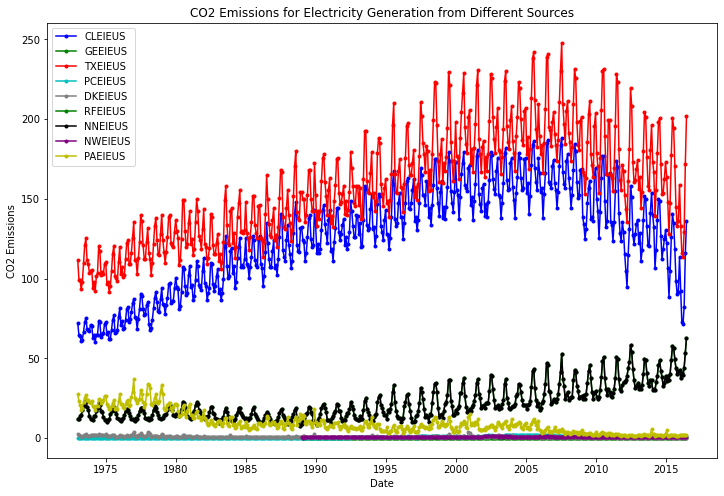

In [12]:
#plot time series data for all MSN catergories provided
plt.figure(figsize=(12,8))
plt.plot(dfCL.index, dfCL.Value, color = 'b', marker='.', label='CLEIEUS')
plt.plot(dfGE.index, dfGE.Value, color = 'g', marker='.', label='GEEIEUS')
plt.plot(dfTX.index, dfTX.Value, color = 'r', marker='.', label='TXEIEUS')
plt.plot(dfPC.index, dfPC.Value, color = 'c', marker='.', label='PCEIEUS')
plt.plot(dfDK.index, dfDK.Value, color = 'gray', marker='.', label='DKEIEUS')
plt.plot(dfNN.index, dfNN.Value, color = 'g', marker='.', label='RFEIEUS')
plt.plot(dfNN.index, dfNN.Value, color = 'k', marker='.', label='NNEIEUS')
plt.plot(dfNW.index, dfNW.Value, color = 'purple', marker='.', label='NWEIEUS')
plt.plot(dfPA.index, dfPA.Value, color = 'y', marker='.', label='PAEIEUS')

plt.title('CO2 Emissions for Electricity Generation from Different Sources')
plt.xlabel("Date")
plt.ylabel("CO2 Emissions")
plt.legend()
plt.show()

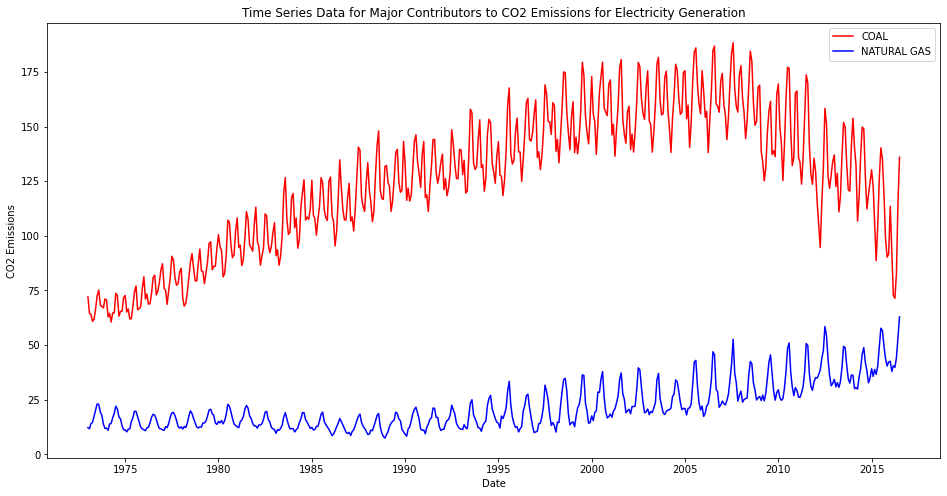

In [13]:
#plot time series data for main contributors and total
plt.figure(figsize=(16,8))
plt.plot(dfCL.index, dfCL.Value, color = 'r', label='COAL')
plt.plot(dfNN.index, dfNN.Value, color = 'b',label='NATURAL GAS')
#plt.plot(dfTX.index, dfTX.Value, color = 'r', label='TOTAL')
plt.title('Time Series Data for Major Contributors to CO2 Emissions for Electricity Generation')
plt.xlabel("Date")
plt.ylabel("CO2 Emissions")
plt.legend()
plt.show()

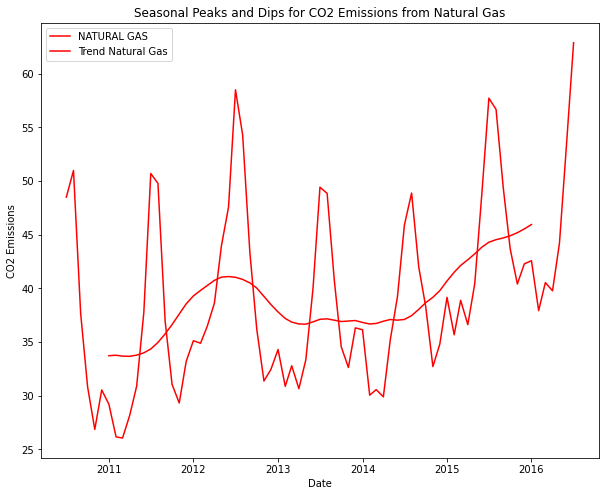

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(dfNN.loc['2010-07-01':'2016-07-01'].Value)
trendNN=decomp.trend
decomp2 = seasonal_decompose(dfCL.loc['2010-07-01':'2016-07-01'].Value)
trendCL=decomp2.trend
#zoom in to observe peaks and dips in seasonality
plt.figure(figsize=(10,8))
plt.plot(dfNN.loc['2010-07-01':'2016-07-01'].index, dfNN.loc['2010-07-01':'2016-07-01'].Value, color = 'r',label='NATURAL GAS')
#plt.plot(dfCL.loc['2010-07-01':'2016-07-01'].index, dfCL.loc['2010-07-01':'2016-07-01'].Value, color = 'b',label='COAL')
plt.plot(trendNN, label='Trend Natural Gas',color = 'r')
#plt.plot(trendCL, label='Trend Coal',color = 'b')
plt.title('Seasonal Peaks and Dips for CO2 Emissions from Natural Gas')
plt.xlabel("Date")
plt.ylabel("CO2 Emissions")
plt.legend()
plt.show()

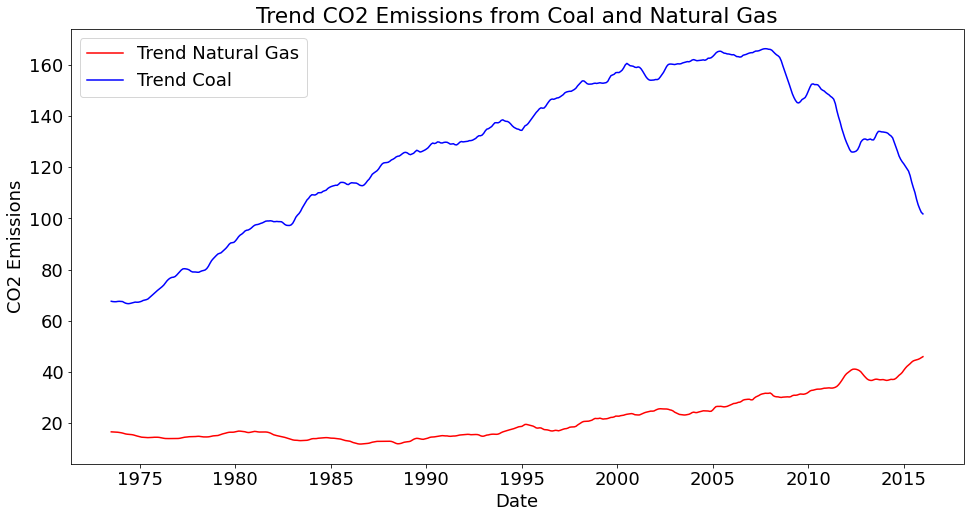

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(dfNN.loc['1973-01-01':'2016-07-01'].Value)
trendNN=decomp.trend
decomp2 = seasonal_decompose(dfCL.loc['1973-01-01':'2016-07-01'].Value)
trendCL=decomp2.trend
#zoom in to observe peaks and dips in seasonality
plt.figure(figsize=(16,8))
plt.rcParams['font.size'] = 18
#plt.plot(dfNN.loc['1973-01-01':'2016-07-01'].index, dfNN.loc['1973-01-01':'2016-07-01'].Value, color = 'r',label='NATURAL GAS')
#plt.plot(dfCL.loc['1973-01-01':'2016-07-01'].index, dfCL.loc['1973-01-01':'2016-07-01'].Value, color = 'b',label='COAL')
plt.plot(trendNN, label='Trend Natural Gas',color = 'r')
plt.plot(trendCL, label='Trend Coal',color = 'b')
plt.title('Seasonal Peaks and Dips for CO2 Emissions from Natural Gas')
plt.title('Trend CO2 Emissions from Coal and Natural Gas')
plt.xlabel("Date")
plt.ylabel("CO2 Emissions")
plt.legend()
plt.show()

In [16]:
# Check description for the highest CO2 emission value types
print(set(dfTX['Description'])) 
print(set(dfCL['Description'])) 
print(set(dfNN['Description'])) 

{'Total Energy Electric Power Sector CO2 Emissions'}
{'Coal Electric Power Sector CO2 Emissions'}
{'Natural Gas Electric Power Sector CO2 Emissions'}


In [17]:
#Quantify emissions for Jun 2016
listmax=[dfCL.Value[-1],dfPC.Value[-1],dfNN.Value[-1],dfDK.Value[-1],dfRF.Value[-1],dfNW.Value[-1],dfPA.Value[-1],dfGE.Value[-1]]
listnames=['Coal','Petroleum Coke','Natural Gas','Distillate Fuel','Residual Fuel Oil','Non-Biomass Waste','Petroleum','Geothermal']

In [18]:
dfCL.index[-1]

Timestamp('2016-07-01 00:00:00')

In [19]:
df_all = pd.DataFrame(list(zip(listnames, listmax)),
               columns =['Type', 'CO2 emissions Jul-2016'])
df_all.head(8)

,Type,CO2 emissions Jul-2016
0,Coal,135.958
1,Petroleum Coke,1.137
2,Natural Gas,62.881
3,Distillate Fuel,0.342
4,Residual Fuel Oil,0.662
5,Non-Biomass Waste,0.943
6,Petroleum,2.141
7,Geothermal,0.035


Peak CO2 emissions Jul-2016:


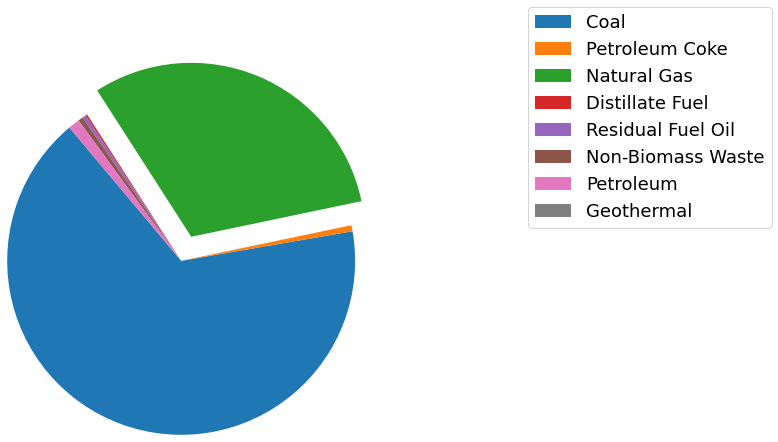

In [20]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
plt.rcParams['font.size'] = 18
print(color.BOLD + 'Peak CO2 emissions Jul-2016:' + color.END)
#plt.title('Center Title')
#plt.title('Left Title', loc='left')
#plt.title('Right Title', loc='right')
labels=list(listnames)
#pie = plt.pie(df_all['CO2 emissions Jul-2016'], startangle=0, autopct='%1.1f%%',labels=labels,radius=3,explode=[0,0,0.3,0,0,0,0,0])
pie = plt.pie(df_all['CO2 emissions Jul-2016'], startangle=130,radius=2,explode=[0,0,0.3,0,0,0,0,0])

plt.legend(pie[0],labels, bbox_to_anchor=(1.9,1), loc="center right", fontsize=18, 
           bbox_transform=plt.gcf().transFigure)
plt.show()


In [21]:
#check dataframe of highest interest dfNN, holding only data for NNEIEUS.  See first lines.
cols=['MSN','Description']
dfNN=dfNN.drop(cols,axis=1)
dfNN[dfNN.Value==np.nan]
dfNN.tail()

,Value
Date,
2016-03-01,40.525
2016-04-01,39.763
2016-05-01,44.210
2016-06-01,53.567
2016-07-01,62.881


In [22]:
# #duplicate dfNN, add column Date if needed
dfNN2=dfNN.copy()
dfNN2['Date']=dfNN2.index.values
dfNN2 = dfNN2.reindex(columns=['Date', 'Value'])
dfNN_original=dfNN2.copy()  #extra copy
dfNN2.head()

,Date,Value
Date,,
1973-01-01,1973-01-01,12.175
1973-02-01,1973-02-01,11.708
1973-03-01,1973-03-01,13.994
1973-04-01,1973-04-01,14.627
1973-05-01,1973-05-01,17.344


In [23]:
#Use interactive plotly to see where peaks and dips occur
import plotly.express as px
df = dfNN2.loc['2012-07-01':'2016-07-01']
fig = px.line(df, x=df.Date, y=df.Value,
              hover_data={ 'Date': "|%B %d, %Y"},
              title='custom tick labels')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

# ***Decompose the different time series for NNEIEUS to check their different components***

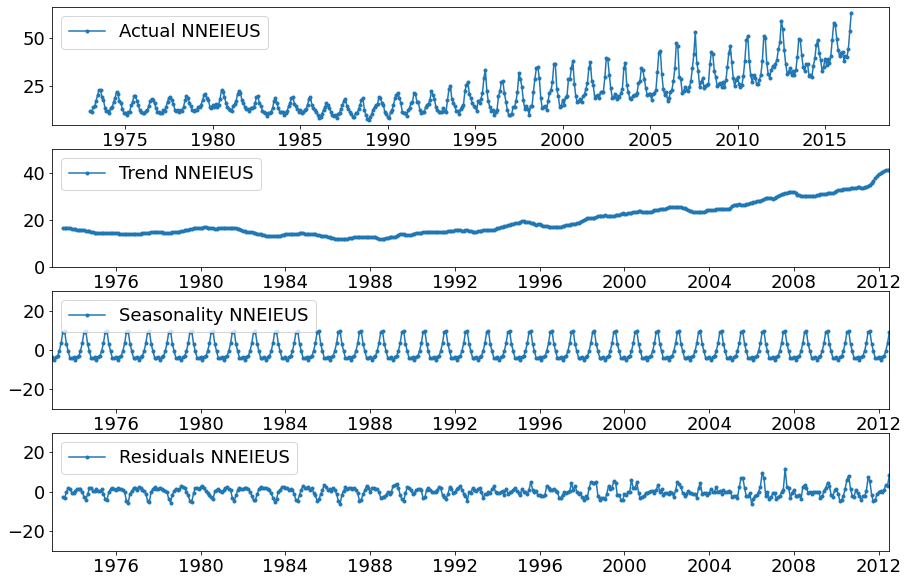

In [24]:
# For df_train showing the marked seasonality
#Importing the seasonal_decompose to decompose the time series (dfNN)
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(dfNN)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(dfNN, label='Actual NNEIEUS', marker='.')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend NNEIEUS', marker='.')
plt.axis(['1973-01-01','2012-07-01', 0, 50])
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality NNEIEUS', marker='.')
plt.axis(['1973-01-01','2012-07-01',  -30, 30])
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals NNEIEUS', marker='.')
plt.axis(['1973-01-01','2012-07-01',  -60, 60])
plt.legend(loc='upper left')
plt.tight_layout
plt.axis(['1973-01-01','2012-07-01',  -30, 30])
plt.show()

***Observations***
- Data shows strong seasonality with 12 month period.
- In trend, two slopes observed flat for early dates roughly (1973-1990) and a slope afterwards 
- Some truncation of original data set was used to isolate single trend that reaches the later dates and found to be better data set for prediction.
- Through exploration found best tradeoff to have maximum data points while only keeping trend with positive slope.

# Modeling Plan

- Given the strong seasonality in the data, two models that handle seasonality well will be compared through cross-validation

 1) SARIMA with hyperparameter optimization using autoarima

 2) FB Prophet model
 

- Given the change in trend behavior observe near the early 1990's, earlier data with a flatter trend will be discarded in the model.


# MODEL#1 : SARIMA


***Optimization of SARIMA hyperparameters through several methods*** 

- Grid optimization with p,d,q in range(0,2) and using period 12 for seasonal differencing.  Minimization of rmse suggests : (pdq)x(P,D,Q,S) = (1, 1, 1)x(1, 0, 1, 12)

- Optimization with auto_arima, using aic metric Best Model: SARIMAX(1, 1, 1)x(1, 0, 1, 12)
- Stepwise model auto_arima with S=12 and D=0 with aic minimization Best model: ARIMA(1,1,1)(1,0,1)(12)

- Run an initial train/test check before running the cross-validation, using 30% of the data for test. 
- Next, more detailed validation using cross-validation.

In [25]:
# Reload data from dfNN - model should not see test data
df_train = dfNN.loc['1996-07-01':'2012-01-01'] #15 and half years for training 
df_test = dfNN.loc['2012-01-01' :'2016-07-01'] #4 and a half years for testing (30%)

print("leaving", round(100*df_test.shape[0]/df_train.shape[0],1), "% of the data for testing purposes.")

leaving 29.4 % of the data for testing purposes.


In [26]:
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import statsmodels.api as sm
#import pmdarima as pm
import itertools
p=d=q=range(0,2)
pdq=list(itertools.product(p,d,q))

pdqs=[(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]
ans=[]

for comb in pdq:
    for combs in pdqs:
        try:
            #print(combs)
            mod=sm.tsa.statespace.SARIMAX(df_train,order=comb,seasonal_order=combs,enforce_stationarity=False,enforce_invertibility=False)
            res = mod.fit()           
            myrmse=mean_squared_error(res.predict(),df_train['Value'], squared=False)
            ans.append([comb,combs,res.aic,myrmse])
        except:
            ans_df['aic']= np.nan
            ans_df['rmse']= np.nan
            continue

ans_df=pd.DataFrame(ans,columns=['pdq','pdqs','aic','rmse']) 
#ans_df.info()
ans_df.loc[ans_df['rmse'].idxmin()]



pdq         (1, 1, 1)
pdqs    (1, 0, 1, 12)
aic           780.983
rmse          3.06862
Name: 61, dtype: object

In [27]:
# Observe top 3 sets of hyperparameters - obtained from optimization
ans_df.sort_values('rmse',ascending=True).head(3)

,pdq,pdqs,aic,rmse
61,"(1, 1, 1)","(1, 0, 1, 12)",780.983008,3.068617
63,"(1, 1, 1)","(1, 1, 1, 12)",725.540204,3.122499
59,"(1, 1, 1)","(0, 1, 1, 12)",723.540167,3.122537


***Observation***
- Based on rmse, SARIMA(1,1,1)x(1,0,1,12) is optimum
- Next check autoarima with  scoring='mse'

In [28]:
# Check agreement with auto_arima from pmdarima 
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import statsmodels.api as sm

auto_arima(df_train['Value'],seasonal=True,m=12,scoring='mse').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  187
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -426.853
Date:                            Thu, 02 Feb 2023   AIC                            863.707
Time:                                    11:03:23   BIC                            879.835
Sample:                                         0   HQIC                           870.243
                                            - 187                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5003      0.078      6.437      0.000       0.348       0.653
ma.L1         -0.9603      0.028    -34.627      0.000      -1.015      -0.906
ar.S.L12       0.9959      0.004    272.265      0.000       0.989       1.003
ma.S.L12      -0.7863      0.072    -10.939      0.000      -0.927      -0.645
sigma2         4.8161      0.368     13.074      0.000       4.094       5.538
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                55.01
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                             0.60
Prob(H) (two-sided):                  0.40   Kurtosis:                         5.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
# from pmdarima.arima import auto_arima
stepwise_model = auto_arima(df_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
#stepwise_model.aic()
stepwise_model

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1064.948, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1158.525, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=963.387, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1063.721, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1156.537, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1135.502, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=897.366, Time=0.29 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1065.832, Time=0.12 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=899.278, Time=0.88 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=899.250, Time=1.04 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1032.075, Time=0.50 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.81 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=905.084, Time=0.23 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [30]:
#Define mape for cross validation. MAPE being 'percent' is convenient for interpretation together with rmse.
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


# Results for optimization of SARIMA model hyperparameters :
- Grid optimization with p,d,q in range(0,2) and using period 12 for seasonal differencing.  
Minimization of rmse suggests :   (pdq)x(P,D,Q,S) = (1, 1, 1)x(1, 0, 1, 12)
- Optimization with auto_arima, using aic metric
Best Model:	SARIMAX(1, 1, 1)x(1, 0, 1, 12)
- Explored stepwise model auto_arima with S=12 and D=0 with aic minimization
Best model:  ARIMA(1,1,1)(1,0,1)(12)  

- All optimization techniques point to same hyperparameters (pdq)x(P,D,Q,S) = (1, 1, 1)x(1, 0, 1, 12)

# Build and fit SARIMA(1,1,1)x(1,0,1,12) model


In [31]:
# Reload data from dfNN - model should not see test data
df_train = dfNN.loc['1996-07-01':'2012-01-01']
df_test = dfNN.loc['2012-01-01' :'2016-07-01']  

print("leaving", round(100*df_test.shape[0]/df_train.shape[0],1), "% of the data for testing purposes.")

leaving 29.4 % of the data for testing purposes.


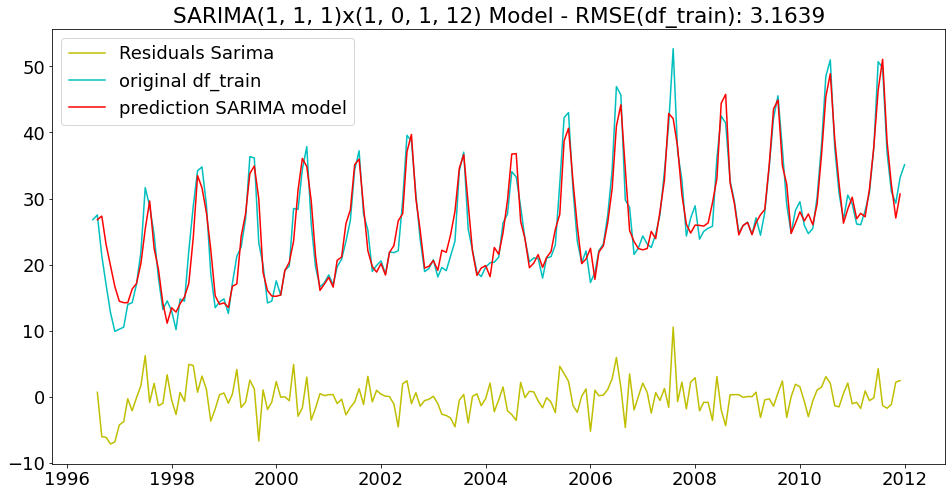

The mean absolute percentage error (MAPE) is  8.29


In [32]:
# Build and fit the SARIMA model  (1, 1, 1)x(1, 0, 1, 12)

from statsmodels.tsa.statespace.sarimax import SARIMAX
model_SA=SARIMAX(df_train,order=(1,1,1),seasonal_order=(1, 0, 1, 12))
result_SA=model_SA.fit()

prediction_SA=result_SA.predict()
fittedvalues_SA=pd.Series(result_SA.fittedvalues)


# Extract residuals for SARIMA(1,1,1)x(1,0,1,12)
df_residuals= pd.DataFrame()
df_residuals['Date']=df_train.index.values
residuals = [df_train.Value[i]-prediction_SA[i] for i in range(len(prediction_SA))]
df_residuals['Res']=residuals
df_residuals=df_residuals.reset_index(drop=True)
df_residuals = df_residuals.set_index(['Date'])


plt.figure(figsize=(16,8))
plt.plot(df_residuals[1:-1],label ='Residuals Sarima', color='y')
plt.plot(df_train,label ='original df_train', color='c')
plt.plot(prediction_SA[1:-1], color='red',label='prediction SARIMA model')
#plt.plot(fittedvalues_SA, color='c',label='fitted values SARIMA model')
plt.title('SARIMA(1, 1, 1)x(1, 0, 1, 12) Model - RMSE(df_train): %.4f'% mean_squared_error(prediction_SA,df_train['Value'], squared=False))
plt.legend()
plt.show()

print('The mean absolute percentage error (MAPE) is ',round(mape(df_train['Value'],prediction_SA),2))

In [33]:
#Forecasting the values for next 55 months- using SARIMA (1,0,1)(1,0,1,12).  This time frame corresponds to the test data
forecasted_SA =result_SA.forecast(steps=55)
index = pd.date_range('2012-01-01','2016-08-01' , freq='1M')- pd.offsets.MonthBegin(1)
df_forecast_test = pd.DataFrame()
df_forecast_test['forecasted test'] =forecasted_SA
df_forecast_test.index = index

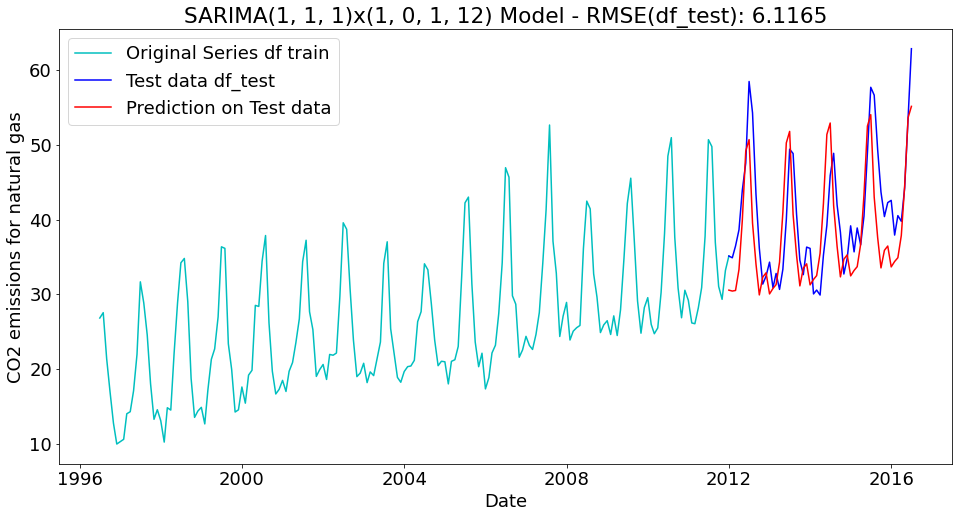

The mean absolute percentage error (MAPE) on test data is  12.03


In [34]:
#Plotting test vs predicted series on test
plt.figure(figsize=(16,8))
plt.plot(df_train, color = 'c', label = 'Original Series df train')
plt.plot(df_test, label = 'Test data df_test', color='b')  #plot the forecasted ARIMA series

plt.plot(df_forecast_test, label = 'Prediction on Test data', color='r')  #plot the forecasted ARIMA series
plt.title('SARIMA(1, 1, 1)x(1, 0, 1, 12) Model - RMSE(df_test): %.4f'% mean_squared_error(forecasted_SA,df_test['Value'], squared=False))
plt.xlabel('Date')
plt.ylabel('CO2 emissions for natural gas')
plt.legend()
plt.show()
print('The mean absolute percentage error (MAPE) on test data is ',round(mape(df_test['Value'],forecasted_SA),2))

In [35]:
#Forecasting the values for next 67 months (starting from end of train period until end of desired prediction)- using SARIMA. "Future" here means beyond existing data set.
# model needs to forecast from end of train data 60+7 months
index_future = pd.date_range('2012-01-01','2017-08-01' , freq='1M')- pd.offsets.MonthBegin(1)
future_forecast_SA =result_SA.forecast(steps=67)

df_future = pd.DataFrame()
df_future['future forecast'] =future_forecast_SA 
df_future.index = index_future
df_future=df_future.loc['2016-02-01':'2017-07-01']
df_future.head()

,future forecast
2016-02-01,34.381007
2016-03-01,34.882928
2016-04-01,37.861008
2016-05-01,44.449741
2016-06-01,53.637069


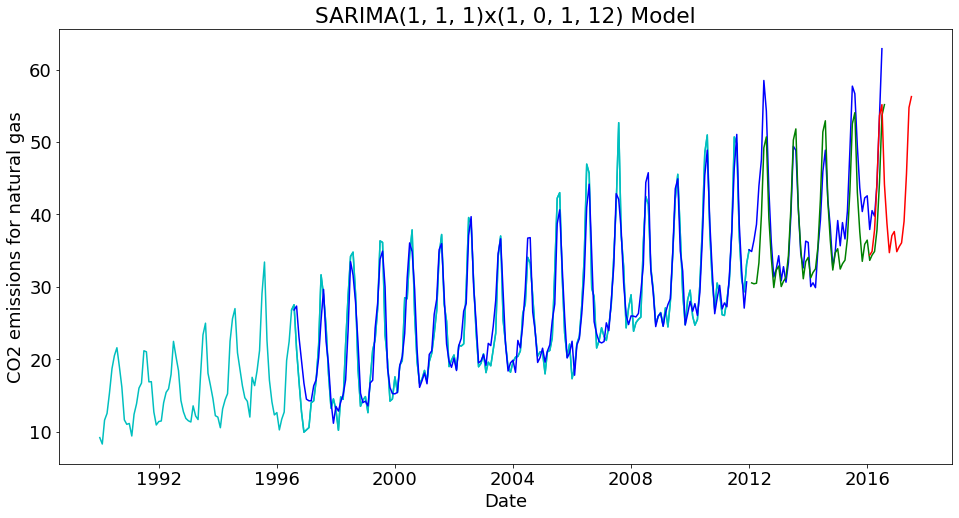

In [36]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
dfplot=dfNN.loc['1990-01-01':'2012-01-01']
plt.plot(dfplot, label = 'original', color='c')  #plot the original series
plt.plot(df_train, label = 'train data', color='c')  #plot the original series
plt.plot(df_test, label = 'test data', color='b')  #plot the original 
plt.plot(prediction_SA[1:-1], color = 'b', label = 'Prediction Train data') #plot the predictions ARIMA series
plt.plot(forecasted_SA, color = 'g', label = 'Prediction Test data') #plot the predictions ARIMA series
plt.plot(df_future, color = 'r', label = 'Prediction beyond available data 2016/07-2017/07')
plt.xlabel('Date')
plt.ylabel('CO2 emissions for natural gas')
plt.title('SARIMA(1, 1, 1)x(1, 0, 1, 12) Model')

#plt.plot(forecasted_ARIMA, label = 'Prediction on Test data', color='g')  #plot the forecasted ARIMA series

#plt.legend()
plt.show()

# Cross-Validation for SARIMA(1,1,1)x(1,0,1,12)

In [37]:
# dfNN2 for Cross Validation - choose period for cross validation expand 1990-01 to 2016-07
dfNN['Date'] = dfNN.index.values
dfNN2 = dfNN.loc['1990-01-01':'2016-07-01']
dfNN2=dfNN2.reset_index(drop=True)
dfNN2=dfNN2.reindex(columns=['Date', 'Value'])
dfNN2.head()

,Date,Value
0,1990-01-01,9.182
1,1990-02-01,8.295
2,1990-03-01,11.590
3,1990-04-01,12.530
4,1990-05-01,15.351


In [38]:
# Using a TimeSeriesSplit with n=5.  
# Print out dates for the train and horizon test data ranges and the sizes of all the data sets. 
# Each horizon for cross-validation testing is  is 53 steps.
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

tscv = TimeSeriesSplit(n_splits=5)
X=dfNN2.Date 
y=dfNN2.Value

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("train:",X_train.iloc[0],',',X_train.iloc[X_train.shape[0]-1])
    print("test:",X_test.iloc[0],',',X_test.iloc[X_test.shape[0]-1])
    print("shape train=",X_train.shape)
    print("shape test=",X_test.shape)

train: 1990-01-01 00:00:00 , 1994-06-01 00:00:00
test: 1994-07-01 00:00:00 , 1998-11-01 00:00:00
shape train= (54,)
shape test= (53,)
train: 1990-01-01 00:00:00 , 1998-11-01 00:00:00
test: 1998-12-01 00:00:00 , 2003-04-01 00:00:00
shape train= (107,)
shape test= (53,)
train: 1990-01-01 00:00:00 , 2003-04-01 00:00:00
test: 2003-05-01 00:00:00 , 2007-09-01 00:00:00
shape train= (160,)
shape test= (53,)
train: 1990-01-01 00:00:00 , 2007-09-01 00:00:00
test: 2007-10-01 00:00:00 , 2012-02-01 00:00:00
shape train= (213,)
shape test= (53,)
train: 1990-01-01 00:00:00 , 2012-02-01 00:00:00
test: 2012-03-01 00:00:00 , 2016-07-01 00:00:00
shape train= (266,)
shape test= (53,)


In [39]:
from sklearn.metrics import mean_absolute_error as mae
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
X=dfNN2.Date 
y=dfNN2.Value

tscv = TimeSeriesSplit(n_splits=5)

rmse = []
xmiddle=[]
teststart=[]
testend=[]
predstart=[]
forecaststart=[]
mapelist=[]
maelist=[]
n=0;
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    data={'Date':X_train,'Value':y_train}
    datatest={'Date':X_test,'Value':y_test}
    df_train=pd.DataFrame(data)
    df_train=df_train.set_index(['Date'])
    df_test=pd.DataFrame(datatest)
    df_test=df_test.set_index(['Date'])
 
 
    # Build and Fit optimized SARIMA model over train/test in this iteration
    model_SA=SARIMAX(df_train,order=(1,1,1),seasonal_order=(1, 0, 1, 12))
    result_SA=model_SA.fit(disp=False)
    
    
    #predictions must predict over df_test
    forecasted_horizon =result_SA.forecast(steps=53)
    forecaststart.append(forecasted_horizon.index[0])

    teststart.append(df_test.index[0])
    testend.append(df_test.index[-1])
    xmiddle.append(X_test.iloc[26])
    
   
#calculate MAE
    val_mae=mae(y_test, forecasted_horizon)
    
    val_rmse=mean_squared_error(y_test, forecasted_horizon, squared=False)
    val_mape=mape(y_test,forecasted_horizon)
    rmse.append(round(val_rmse,2))
    mapelist.append(round(val_mape,2))
    val_mae=mae(y_test, forecasted_horizon)
    maelist.append(round(val_mae,2))



# Cross-Validation Summary for SARIMA

In [40]:
#Create summary dataframe with results from the SARIMA n=5 cross-validation
CVSARIMA_df=pd.DataFrame(rmse, columns=["CV SARIMA(111)(10112) rmse"])
CVSARIMA_df["CV SARIMA(111)(10112) mape"] = mapelist
CVSARIMA_df["CV SARIMA(111)(10112) mae"] = maelist
CVSARIMA_df["Start horizon date"] = teststart
CVSARIMA_df["End horizon date"] = testend
CVSARIMA_df["Middle of horizon period"] = xmiddle
#CVSARIMA_df["Forecast start"] = forecaststart
print("SARIMA(1,1,1)(1,0,1,12) Cross-Validation Summary")
#Result_df["mape"]=mape
CVSARIMA_df.head()
#print(rmse)
#print(mape)

SARIMA(1,1,1)(1,0,1,12) Cross-Validation Summary


,CV SARIMA(111)(10112) rmse,CV SARIMA(111)(10112) mape,CV SARIMA(111)(10112) mae,Start horizon date,End horizon date,Middle of horizon period
0,3.85,13.61,2.80,1994-07-01,1998-11-01,1996-09-01
1,3.41,12.43,2.88,1998-12-01,2003-04-01,2001-02-01
2,3.14,8.39,2.33,2003-05-01,2007-09-01,2005-07-01
3,2.46,5.67,1.85,2007-10-01,2012-02-01,2009-12-01
4,4.45,8.19,3.54,2012-03-01,2016-07-01,2014-05-01


# FB Prophet Model

In [41]:
# Depiction of time partition used
import plotly.express as px
df = dfNN
fig = px.line(df, x=df.Date, y=df.Value, title='Cross-Validation Time Partition')

fig.add_scatter(x=[teststart[0]]*100, y=np.linspace(-0,60,100), name='cv test period 1')
fig.add_scatter(x=[teststart[1]]*100, y=np.linspace(-0,60,100), name='cv test period 2')
fig.add_scatter(x=[teststart[2]]*100, y=np.linspace(-0,60,100), name='cv test period 3')
fig.add_scatter(x=[teststart[3]]*100, y=np.linspace(-0,60,100), name='cv test period 4')
fig.add_scatter(x=[teststart[4]]*100, y=np.linspace(-0,60,100), name='cv test period 5')

fig.show()

In [42]:
import fbprophet
from fbprophet import Prophet

dfNN = dfNN.loc['1990-01-01':'2016-07-01']
dfNN=dfNN.rename(columns={'Value': 'y'})
dfNN=dfNN.rename(columns={'Date': 'ds'})

dfNN['ds'] = dfNN['ds'].astype('datetime64[ns]')

dfNN['Date'] = dfNN.ds
dfNN = dfNN.set_index(['Date'])

# dfNN - exclude old data with flat trend
dfNN = dfNN.loc['1990-01-01':'2016-07-01']
dfNN.shape

(319, 2)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


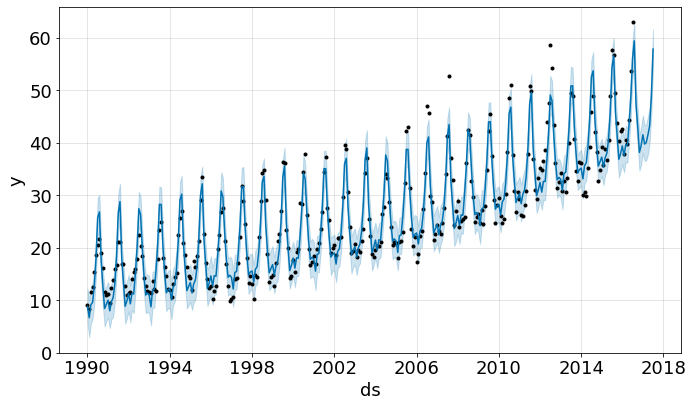

In [43]:
m = Prophet(weekly_seasonality=False,daily_seasonality=False)
m.fit(dfNN)
future = m.make_future_dataframe(periods=12,freq="M")
forecast = m.predict(future)
fig = m.plot(forecast)

In [44]:
# Extract residuals for prophet
df_residualsP= pd.DataFrame()
df_residualsP['Date']=dfNN['ds']
forecast_over_existing=forecast.yhat[0:319]
residualsP = [dfNN.y[i]-forecast_over_existing[i] for i in range(len(forecast_over_existing))]
df_residualsP['ResP']=residualsP
df_residualsP=df_residualsP.reset_index(drop=True)
df_residualsP = df_residualsP.set_index(['Date'])
df_residualsP.head()

,ResP
Date,
1990-01-01,0.395798
1990-02-01,1.625148
1990-03-01,2.486269
1990-04-01,2.942045
1990-05-01,2.765786


In [45]:
ProphetForecast2017= pd.DataFrame()
ProphetForecast2017['Date']=forecast.ds[312:-1]
ProphetForecast2017['Value']=forecast.yhat[312:-1]
ProphetForecast2017=ProphetForecast2017.reset_index(drop=True)
ProphetForecast2017 = ProphetForecast2017.set_index(['Date'])
ProphetForecast2017.tail()
forecast.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1990-01-01,13.747073,5.631268,12.157962,13.747073,13.747073,-4.960870,-4.960870,-4.960870,-4.960870,-4.960870,-4.960870,0.0,0.0,0.0,8.786202
1,1990-02-01,13.818908,2.984158,10.218458,13.818908,13.818908,-7.149056,-7.149056,-7.149056,-7.149056,-7.149056,-7.149056,0.0,0.0,0.0,6.669852
2,1990-03-01,13.883792,5.519006,12.534323,13.883792,13.883792,-4.780061,-4.780061,-4.780061,-4.780061,-4.780061,-4.780061,0.0,0.0,0.0,9.103731
3,1990-04-01,13.955627,6.398849,13.198318,13.955627,13.955627,-4.367673,-4.367673,-4.367673,-4.367673,-4.367673,-4.367673,0.0,0.0,0.0,9.587955
4,1990-05-01,14.025146,9.058142,16.171788,14.025146,14.025146,-1.439932,-1.439932,-1.439932,-1.439932,-1.439932,-1.439932,0.0,0.0,0.0,12.585214


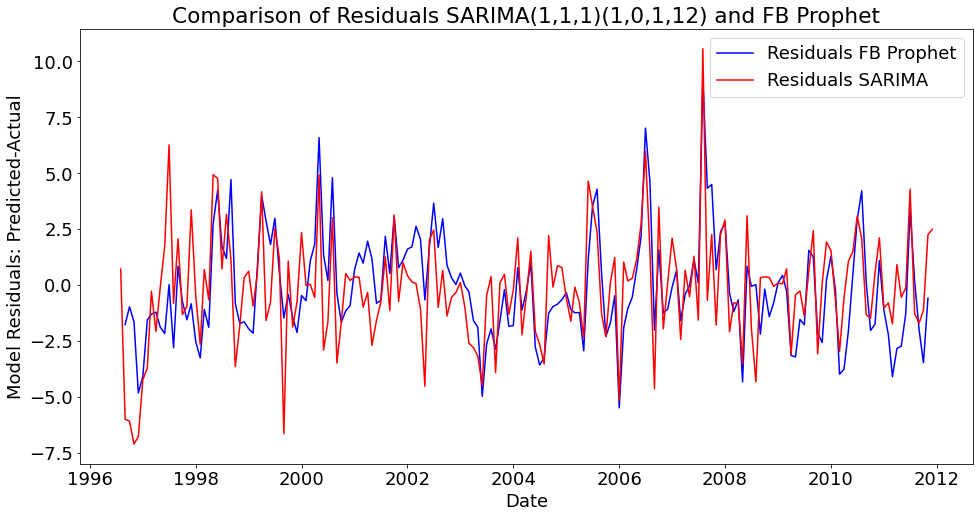

In [46]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df_residualsP[80:-56], label = 'Residuals FB Prophet', color='b')  #plot the original series
plt.plot(df_residuals[1:-1], label = 'Residuals SARIMA', color='r')  #plot the original series

plt.title('Comparison of Residuals SARIMA(1,1,1)(1,0,1,12) and FB Prophet')
plt.xlabel('Date')
plt.ylabel('Model Residuals: Predicted-Actual')
plt.legend()
plt.show()


In [47]:
import fbprophet
from fbprophet import Prophet

dfNN = dfNN.loc['1990-01-01':'2016-07-01']
dfNN=dfNN.rename(columns={'Value': 'y'})
dfNN=dfNN.rename(columns={'Date': 'ds'})

dfNN['ds'] = dfNN['ds'].astype('datetime64[ns]')

dfNN['Date'] = dfNN.ds
dfNN = dfNN.set_index(['Date'])

# dfNN - exclude old data with flat trend
dfNN = dfNN.loc['1990-01-01':'2016-07-01']
dfNN.shape

(319, 2)

In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
X=dfNN['ds']
y=dfNN['y']

tscv = TimeSeriesSplit(n_splits=5)
print(tscv)
rmse = []
xpoint=[]
teststart=[]
mapelist=[]
predstart=[]
teststart_str=[]
predstart_str=[]
maelist=[]
n=1;
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    data={'ds':X_train,'y':y_train}
    
    datatest={'ds':X_test,'y':y_test}
    df_train=pd.DataFrame(data)
    df_train=df_train.reset_index()

    df_test=pd.DataFrame(datatest)
    df_test=df_test.reset_index()
    df_train.drop(['Date'], axis=1, inplace=True)  
    df_test.drop(['Date'], axis=1, inplace=True)  

   
    
    m = Prophet(weekly_seasonality=False,daily_seasonality=False)
    m.fit(df_train)
    future = m.make_future_dataframe(periods=54,freq="M")
    predictions = m.predict(future)
    
    predictions1=predictions.tail(53)
    predictions1.reset_index()
    
   
    teststart.append(X_test.iloc[0])
    predstart.append(predictions1.ds[predictions1.index[0]])    
    xpoint.append(X_test.iloc[26])
    
    val_mae=mae(y_test,predictions1.yhat)
    maelist.append(round(val_mae,2))
    
    val_rmse=mean_squared_error(y_test,predictions1.yhat, squared=False)
    rmse.append(round(val_rmse,2))
    val_mape=mape(y_test,predictions1.yhat)
    mapelist.append(round(val_mape,2))
    
    teststart_str.append(X_test.iloc[0].strftime('%b-%Y'))
    predstart_str.append(predictions1.ds[predictions1.index[0]].strftime('%b-%Y'))
    #print("shape of predictions=",predictions1.yhat.shape)
    #print("shapeof test=",y_test.shape)
    print("teststart=",teststart_str)
    print("predstart=", predstart_str)


TimeSeriesSplit(max_train_size=None, n_splits=5)
teststart= ['Jul-1994']
predstart= ['Jul-1994']
teststart= ['Jul-1994', 'Dec-1998']
predstart= ['Jul-1994', 'Dec-1998']
teststart= ['Jul-1994', 'Dec-1998', 'May-2003']
predstart= ['Jul-1994', 'Dec-1998', 'May-2003']
teststart= ['Jul-1994', 'Dec-1998', 'May-2003', 'Oct-2007']
predstart= ['Jul-1994', 'Dec-1998', 'May-2003', 'Oct-2007']
teststart= ['Jul-1994', 'Dec-1998', 'May-2003', 'Oct-2007', 'Mar-2012']
predstart= ['Jul-1994', 'Dec-1998', 'May-2003', 'Oct-2007', 'Mar-2012']


In [49]:
#Create summary dataframe with results from the Prophet n=5 cross-validation
CVProphet_df = pd.DataFrame()
CVProphet_df=pd.DataFrame(rmse, columns=["CV Prophet rmse"])
CVProphet_df["CV Prophet mape"] = mapelist
CVProphet_df["CV Prophet mae"] = maelist

CVProphet_df["Start horizon date"] = teststart
CVProphet_df["End horizon date"] = testend
CVProphet_df["Middle of horizon period"] = xpoint

print("FB Prophet Model Cross-Validation Summary")

FB Prophet Model Cross-Validation Summary


In [50]:
print("FB Prophet Model Cross-Validation Summary")
CVProphet_df.head()

FB Prophet Model Cross-Validation Summary


,CV Prophet rmse,CV Prophet mape,CV Prophet mae,Start horizon date,End horizon date,Middle of horizon period
0,5.00,18.06,3.61,1994-07-01,1998-11-01,1996-09-01
1,4.52,13.11,3.33,1998-12-01,2003-04-01,2001-02-01
2,5.99,17.58,4.76,2003-05-01,2007-09-01,2005-07-01
3,5.34,12.55,4.19,2007-10-01,2012-02-01,2009-12-01
4,6.19,11.44,4.85,2012-03-01,2016-07-01,2014-05-01


In [51]:
CVSARIMA_df.head()

,CV SARIMA(111)(10112) rmse,CV SARIMA(111)(10112) mape,CV SARIMA(111)(10112) mae,Start horizon date,End horizon date,Middle of horizon period
0,3.85,13.61,2.80,1994-07-01,1998-11-01,1996-09-01
1,3.41,12.43,2.88,1998-12-01,2003-04-01,2001-02-01
2,3.14,8.39,2.33,2003-05-01,2007-09-01,2005-07-01
3,2.46,5.67,1.85,2007-10-01,2012-02-01,2009-12-01
4,4.45,8.19,3.54,2012-03-01,2016-07-01,2014-05-01


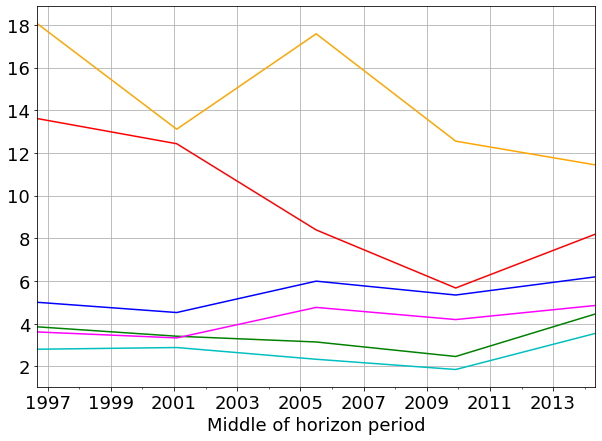

In [52]:
import seaborn as sns
import matplotlib.pylab as plt
figure=plt.figure(figsize=(10,7))
ax=plt.gca()
plt.rcParams['font.size'] = 16
CVSARIMA_df.plot(kind='line',x='Middle of horizon period',y='CV SARIMA(111)(10112) rmse',color='green',ax=ax,grid=True)
CVSARIMA_df.plot(kind='line',x='Middle of horizon period',y='CV SARIMA(111)(10112) mape',color='red',ax=ax,grid=True)
CVSARIMA_df.plot(kind='line',x='Middle of horizon period',y='CV SARIMA(111)(10112) mae',color='c',ax=ax,grid=True)

CVProphet_df.plot(kind='line',x='Middle of horizon period',y='CV Prophet mape',color='orange',ax=ax,grid=True)
CVProphet_df.plot(kind='line',x='Middle of horizon period',y='CV Prophet rmse',color='blue',ax=ax,grid=True)
CVProphet_df.plot(kind='line',x='Middle of horizon period',y='CV Prophet mae',color='magenta',ax=ax,grid=True)

#x = np.linspace(-20, 20, 100)
#plt.axvline(x ='1998-12-01' , c = 'gray')
#plt.axvline(x ='2003-05-01' , c = 'gray')
#plt.axvline(x ='2007-10-01' , c = 'gray')
#plt.axvline(x ='2012-03-01' , c = 'gray')
##plt.axvline(x ='1998-12-01' , c = 'gray')
plt.legend([],[], frameon=False)
#plt.rcParams['font.size'] = 12
plt.show()

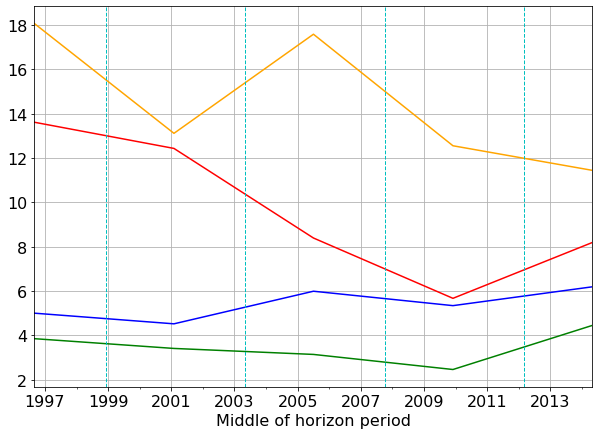

In [53]:
import seaborn as sns
figure=plt.figure(figsize=(10,7))
ax=plt.gca()
plt.rcParams['font.size'] = 12



CVSARIMA_df.plot(kind='line',x='Middle of horizon period',y='CV SARIMA(111)(10112) rmse',color='green',ax=ax,grid=True)
CVSARIMA_df.plot(kind='line',x='Middle of horizon period',y='CV SARIMA(111)(10112) mape',color='red',ax=ax,grid=True)
CVProphet_df.plot(kind='line',x='Middle of horizon period',y='CV Prophet mape',color='orange',ax=ax,grid=True)
CVProphet_df.plot(kind='line',x='Middle of horizon period',y='CV Prophet rmse',color='blue',ax=ax,grid=True)

x = np.linspace(-20, 20, 100)
plt.axvline(x ='1998-12-01' , c = 'c',LineWidth=1, linestyle='--')
plt.axvline(x ='2003-05-01' , c = 'c',LineWidth=1, linestyle='--')
plt.axvline(x ='2007-10-01' , c = 'c',LineWidth=1, linestyle='--')
plt.axvline(x ='2012-03-01' , c = 'c',LineWidth=1, linestyle='--')
plt.axvline(x ='1994-07-01' , c = 'c',LineWidth=1, linestyle='--')
plt.legend([],[], frameon=False)
legend=False
plt.show()

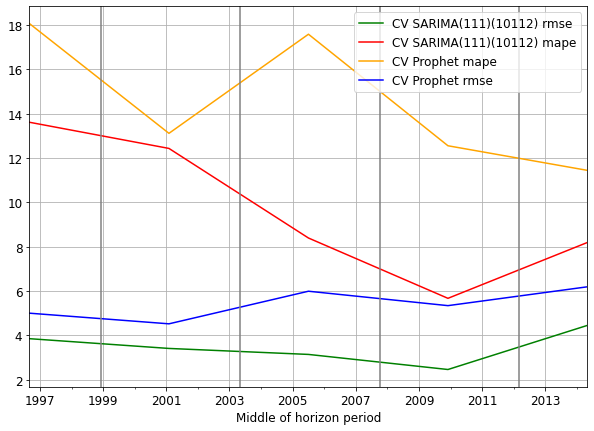

In [54]:
import seaborn as sns
figure=plt.figure(figsize=(10,7))
ax=plt.gca()
plt.rcParams['font.size'] = 12
CVSARIMA_df.plot(kind='line',x='Middle of horizon period',y='CV SARIMA(111)(10112) rmse',color='green',ax=ax,grid=True)
CVSARIMA_df.plot(kind='line',x='Middle of horizon period',y='CV SARIMA(111)(10112) mape',color='red',ax=ax,grid=True)
CVProphet_df.plot(kind='line',x='Middle of horizon period',y='CV Prophet mape',color='orange',ax=ax,grid=True)
CVProphet_df.plot(kind='line',x='Middle of horizon period',y='CV Prophet rmse',color='blue',ax=ax,grid=True)

x = np.linspace(-20, 20, 100)
plt.axvline(x ='1998-12-01' , c = 'gray')
plt.axvline(x ='2003-05-01' , c = 'gray')
plt.axvline(x ='2007-10-01' , c = 'gray')
plt.axvline(x ='2012-03-01' , c = 'gray')
#plt.axvline(x ='1998-12-01' , c = 'gray')
plt.show()

In [55]:
### Try Prophet multiplicative sesonality mode and found worse results
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
X=dfNN['ds']
y=dfNN['y']

tscv = TimeSeriesSplit(n_splits=5)
print(tscv)
rmse = []
xpoint=[]
teststart=[]
mapelist=[]
predstart=[]
n=1;
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    data={'ds':X_train,'y':y_train}
    
    datatest={'ds':X_test,'y':y_test}
    df_train=pd.DataFrame(data)
    df_train=df_train.reset_index()

    df_test=pd.DataFrame(datatest)
    df_test=df_test.reset_index()
    df_train.drop(['Date'], axis=1, inplace=True)  
    df_test.drop(['Date'], axis=1, inplace=True)  

   
    
    m = Prophet(weekly_seasonality=False,daily_seasonality=False,seasonality_mode='multiplicative')
    m.fit(df_train)
    future = m.make_future_dataframe(periods=54,freq="M")
    predictions = m.predict(future)
    
    predictions1=predictions.tail(53)
    predictions1.reset_index()
  
    teststart.append(X_test.iloc[0])
   
    predstart.append(predictions1.ds[predictions1.index[0]])
    
    xpoint.append(X_test.iloc[26])
   
    rmse.append(1*mean_squared_error(y_test,predictions1.yhat, squared=False))
    mapelist.append(mape(y_test,predictions1.yhat))
    
print(rmse)
print(mapelist)

TimeSeriesSplit(max_train_size=None, n_splits=5)
[4.841796636903745, 4.491749594658687, 6.899823573226006, 7.224666692811984, 8.702278238683977]
[17.89307071177432, 14.462685783798065, 18.459640313135317, 17.568133070016444, 17.325173509930394]


In [56]:
#Create summary dataframe with results from the Prophet (multiplicative seasonality instead of additive) n=5 cross-validation
CVProphetM_df = pd.DataFrame()
CVProphetM_df=pd.DataFrame(rmse, columns=["CV ProphetM rmse"])
CVProphetM_df["CV ProphetM mape"] = mapelist
CVProphetM_df["Start horizon date"] = teststart
CVProphetM_df["End horizon date"] = testend
CVProphetM_df["Middle of horizon period"] = xpoint

print("FB Prophet (multiplicative) Model Cross-Validation Summary")
#Result_df["mape"]=mape
CVProphetM_df.head()

FB Prophet (multiplicative) Model Cross-Validation Summary


,CV ProphetM rmse,CV ProphetM mape,Start horizon date,End horizon date,Middle of horizon period
0,4.841797,17.893071,1994-07-01,1998-11-01,1996-09-01
1,4.491750,14.462686,1998-12-01,2003-04-01,2001-02-01
2,6.899824,18.459640,2003-05-01,2007-09-01,2005-07-01
3,7.224667,17.568133,2007-10-01,2012-02-01,2009-12-01
4,8.702278,17.325174,2012-03-01,2016-07-01,2014-05-01


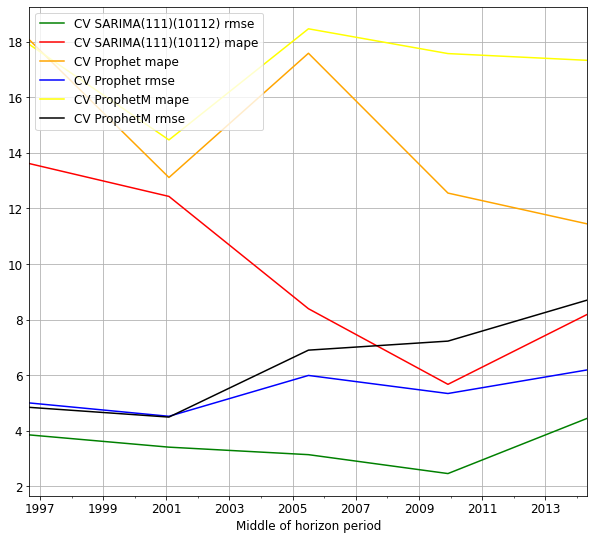

In [57]:
import seaborn as sns
figure=plt.figure(figsize=(10,9))
ax=plt.gca()

CVSARIMA_df.plot(kind='line',x='Middle of horizon period',y='CV SARIMA(111)(10112) rmse',color='green',ax=ax,grid=True,legend=True)
CVSARIMA_df.plot(kind='line',x='Middle of horizon period',y='CV SARIMA(111)(10112) mape',color='red',ax=ax,grid=True)
CVProphet_df.plot(kind='line',x='Middle of horizon period',y='CV Prophet mape',color='orange',ax=ax,grid=True)
CVProphet_df.plot(kind='line',x='Middle of horizon period',y='CV Prophet rmse',color='blue',ax=ax,grid=True)
CVProphetM_df.plot(kind='line',x='Middle of horizon period',y='CV ProphetM mape',color='yellow',ax=ax,grid=True)
CVProphetM_df.plot(kind='line',x='Middle of horizon period',y='CV ProphetM rmse',color='black',ax=ax,grid=True)
plt.show()

Performance is worse for the Prophet model with multiplicative seasonality. 
SARIMA continues to be best. 

# SUMMARY OF MAPE AND RMSE

In [58]:
print("Average Cross-Validation rmse score for FB Prophet is:", CVProphet_df['CV Prophet rmse'].mean())
print("Average Cross-Validation rmse score for SARIMA is:", round(CVSARIMA_df['CV SARIMA(111)(10112) rmse'].mean(),2))
print("Average Cross-Validation rmse score for Propher Mult is:", round(CVProphetM_df['CV ProphetM rmse'].mean(),2))

Average Cross-Validation rmse score for FB Prophet is: 5.408
Average Cross-Validation rmse score for SARIMA is: 3.46
Average Cross-Validation rmse score for Propher Mult is: 6.43


In [59]:
print("Average Cross-Validation mape score for FB Prophet is:", round(CVProphet_df['CV Prophet mape'].mean(),2))
print("Average Cross-Validation mape score for SARIMA is:", round(CVSARIMA_df['CV SARIMA(111)(10112) mape'].mean(),2))
print("Average Cross-Validation mape score for Prophet Mult is:", round(CVProphetM_df['CV ProphetM mape'].mean(),2))

Average Cross-Validation mape score for FB Prophet is: 14.55
Average Cross-Validation mape score for SARIMA is: 9.66
Average Cross-Validation mape score for Prophet Mult is: 17.14


# Comparison of 2016-07 to 2017-07 prediction by best two models
- Prophet with additive seasonality
- SARIMA(1,1,1)x(1,0,1,12)

In [60]:
dfNN2=dfNN_original
dfNN2.head()
dfNN2.drop(['Date'], axis=1, inplace=True)  
dfNN2.head()

,Value
Date,
1973-01-01,12.175
1973-02-01,11.708
1973-03-01,13.994
1973-04-01,14.627
1973-05-01,17.344


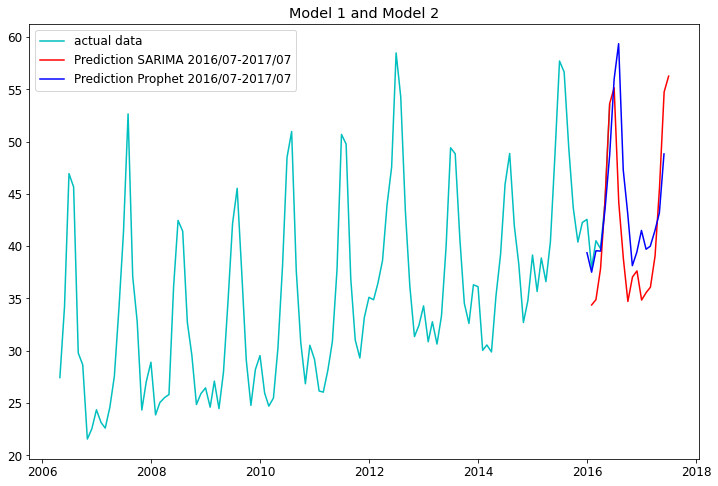

In [61]:
#Plotting the original vs predicted series
plt.figure(figsize=(12,8))
plt.plot(dfNN2[400:-1], label = 'actual data', color='c')  #plot the original series

plt.plot(df_future, color = 'r', label = 'Prediction SARIMA 2016/07-2017/07')
plt.plot(ProphetForecast2017, color = 'b', label = 'Prediction Prophet 2016/07-2017/07')

plt.title('SARIMA(1, 1, 1)x(1, 0, 1, 12) Model')

#plt.plot(forecasted_ARIMA, label = 'Prediction on Test data', color='g')  #plot the forecasted ARIMA series
plt.title('Model 1 and Model 2')
plt.legend()
plt.show()

# Conclusions and Observations

- Both SARIMA(1, 1, 1)x(1, 0, 1, 12) and FB Prophet with additive seasonality were found to show good and similar performance.
- Comparison of both residuals confirms that the predictions are very similar.
- Cross-Validation with 5 time splits over time range between 1990-2016 shows lowest errors for SARIMA(1,1,1)x(1,0,1,12) model with mean average percent error (averaged over the CV horizons) is 9.8%
- Cross-Validation showed lowest RMSE of 3.5% for the SARIMA(1,1,1)x(1,0,1,12) model

***Recommendation for Implementation***

- Recommend SARIMA(1, 1, 1)x(1, 0, 1, 12) which showed 9.8% mean average error percent over rolling window cross-validation
- Forecasted future CO2 emissions should be used as a benchmark for policy evaluation as a comparison reference for actual future data. 
- Future additions to the model of potential exogenous variables influenced by policy changes may allow a similar model to predict difference in CO2 emissions with and without policy change
- Exogenous here means an relevant external time series. We have used SARIMAX which has the capability of exogenous variable (include a separate parallel time series relevant to policy)
- Model is not very computationally demanding and can be run on a variety of cloud servers such as Google Colab (even without enabling GPU)
- If trend changes are observed in more current data, the prophet model (with also good performance) would become beneficial as it has the capability to detect these changes change points.


# Appendix :Earlier exploration of ARIMA models 

In [62]:
#Optimize for p and q by minimizing rmse, aic and bic. Optimization shown for p,q up to 6, but exploration 
#of higher values in the range of 6-12 showed almost no gain and worse performance.

from statsmodels.tsa.arima_model import ARIMA
aic_mat = pd.DataFrame(np.zeros((7,7), dtype=float))
bic_mat = pd.DataFrame(np.zeros((7,7), dtype=float))
rmse_mat = pd.DataFrame(np.zeros((7,7), dtype=float))



# Iterate over all ARMA(p,q) models with p,q in [0,6]
for p in range(7):
    for q in range(7):
        if p == 0 and q == 0:
            continue

        # Estimate the model with no missing datapoints
        mod = ARIMA(df_shift, order=(p,0,q))
        try:
            res = mod.fit(disp=False)
            myrmse=mean_squared_error(res.predict(),df_shift['Value'], squared=False)
            rmse_mat.iloc[p,q] = myrmse
            aic_mat.iloc[p,q] = res.aic
            bic_mat.iloc[p,q] = res.bic
        except:
            rmse_mat.iloc[p,q] = np.nan
            aic_mat.iloc[p,q] = np.nan
            bic_mat.iloc[p,q] = np.nan

            

NameError: name 'df_shift' is not defined

In [ ]:
# find and print minimum AIC, BIC and most importantly rmse
minimums_aic=[]
minimums_bic=[]
minimums_rmse=[]
for q in range(7):
    if q!=0:
        minInColumns_aic = np.amin(aic_mat[q], axis=0)
        minInColumns_bic = np.amin(bic_mat[q], axis=0)
        minInColumns_rmse = np.amin(rmse_mat[q], axis=0)
    #print('min value of every column: ', minInColumns,'for q=', q)
        minimums_aic.append(minInColumns_aic)  
        minimums_bic.append(minInColumns_bic)  
        minimums_rmse.append(minInColumns_rmse)  
        
        
result_aic = np.where(aic_mat == min(minimums_aic))
result_bic = np.where(bic_mat == min(minimums_bic))
result_rmse = np.where(rmse_mat == min(minimums_rmse))
print(result_aic,',', min(minimums_aic))
print(result_bic,',', min(minimums_bic))
print(result_rmse,',', min(minimums_rmse))


(array([6], dtype=int64), array([6], dtype=int64)) , -641.4337646674137
(array([6], dtype=int64), array([6], dtype=int64)) , -586.5692507075896
(array([6], dtype=int64), array([6], dtype=int64)) , 0.09851890828585151


<AxesSubplot:>

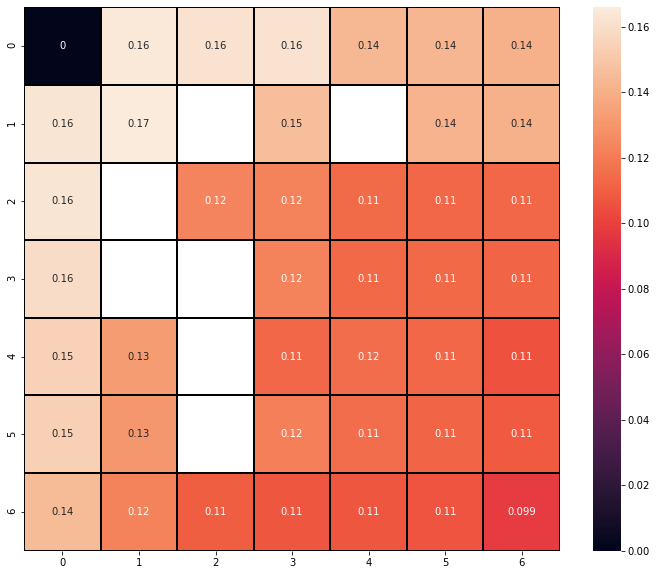

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(rmse_mat, annot=True, linecolor="k", linewidths=1)

<AxesSubplot:>

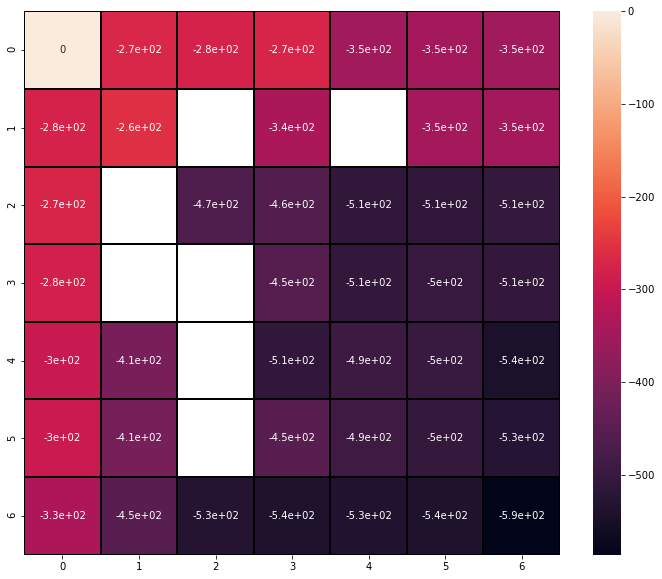

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(bic_mat, annot=True, linecolor="k", linewidths=1)

<AxesSubplot:>

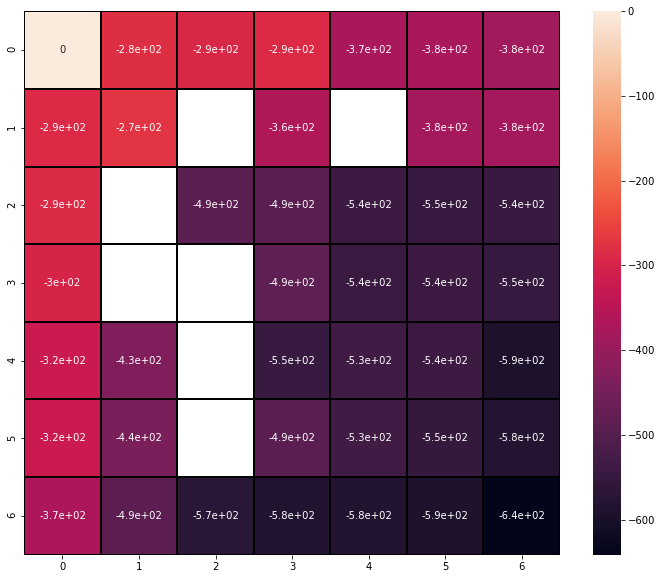

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(aic_mat, annot=True, linecolor="k", linewidths=1)

***Observations***

- Optimization of ARIMA p and q components suggests p=q=6 are optimum.  Higher orders of p and q up to 12 were explored showing little or no gain, and higher complexity in the model.

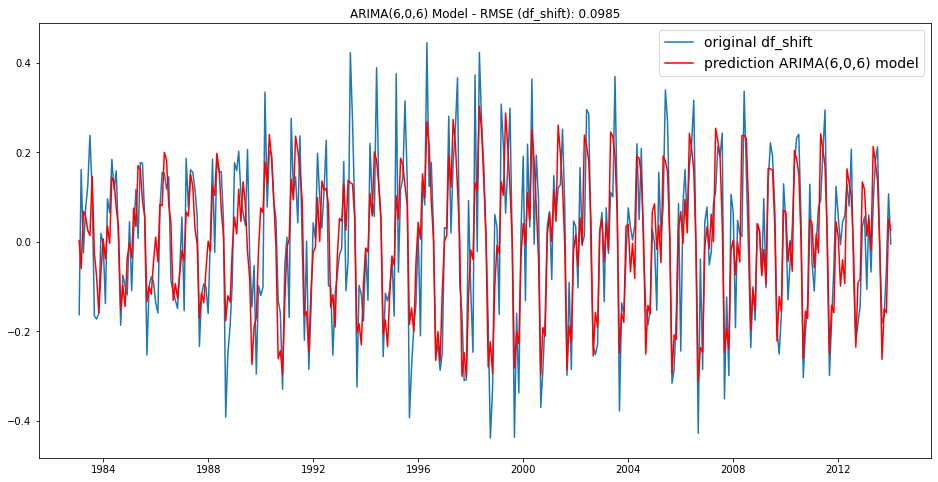

In [ ]:
# Select ARIMA(6,0,6) as optimum
# Exploration of higher order models do not show enough improvement to justify such high complexity.

from statsmodels.tsa.arima_model import ARIMA
model_ARIMA=ARIMA(df_shift, order=(6,0,6)) # (p,d,q) order of the model 
results_ARIMA = model_ARIMA.fit()

plt.figure(figsize=(16,8))
plt.rc('legend',fontsize=14) # set font size

plt.plot(df_shift,label ='original df_shift')
plt.plot(results_ARIMA.predict(), color='red',label='prediction ARIMA(6,0,6) model')
plt.title('ARIMA(6,0,6) Model - RMSE (df_shift): %.4f'% mean_squared_error(results_ARIMA.predict(),df_shift['Value'], squared=False))
plt.legend()
plt.show()

In [ ]:
# Generate series with predictions with reverse transformations (log, difference) over train time range for ARIMA(6,0,6)
predictions=pd.Series(results_ARIMA.fittedvalues)

#Reverse differencing step by doing cumulative sum
predictions_cumsum =predictions.cumsum() # use .cumsum fuction on the predictions

#Add the first value of the log series to the cumulative sum values
predictions_log = pd.Series(df_log['Value'].iloc[0], index=df_log.index)
predictions_log = predictions_log.add(predictions_cumsum, fill_value=0)

#Apply exponential transformation to reverse log 
predictions_ARIMA =np.exp(predictions_log) #use exponential function

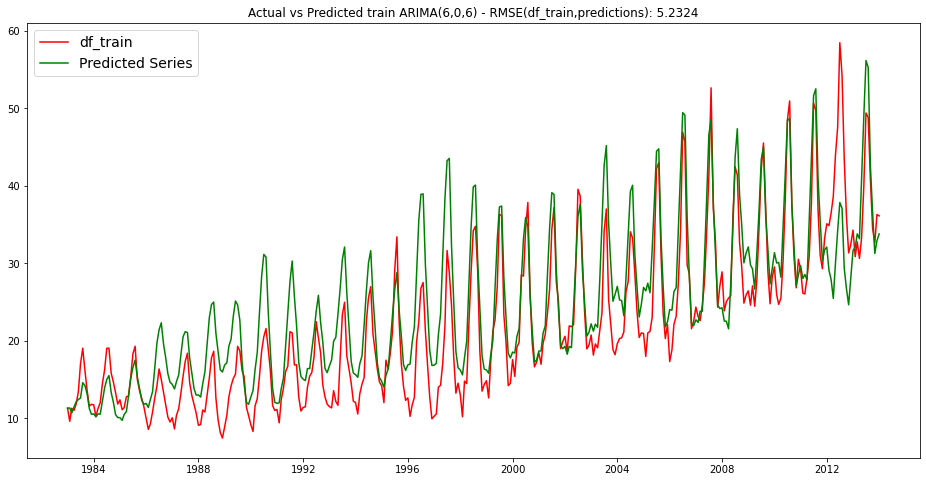

In [ ]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.rc('legend',fontsize=14) # set font 

#plt.plot(dfNN, color = 'c', label = 'Original Series dfNN')  #plot the original train series
plt.plot(df_train, color = 'r', label = 'df_train')  #plot the original train series
plt.plot(predictions_ARIMA, color = 'g', label = 'Predicted Series')  #plot the predictions ARIMA

plt.title('Actual vs Predicted train ARIMA(6,0,6) - RMSE(df_train,predictions): %.4f'% mean_squared_error(predictions_ARIMA,df_train['Value'], squared=False))  #Calculating rmse

plt.legend()
plt.show()


In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

print('The mean absolute percentage error (MAPE), for df_train and ARIMA(6,0,6) prediction is ',round(mape(df_train['Value'],predictions_ARIMA),2))

The mean absolute percentage error (MAPE), for df_train and ARIMA(6,0,6) prediction is  22.32


# Forecast over df_test time range to evaluate the model

In [ ]:
#df_train = dfNN.loc['1983-01-01':'2014-01-01']
#df_test = dfNN.loc['2014-01-01' :'2016-07-01']

In [ ]:
#Forecasting the values for next 31 months- using ARIMA (6,0,6).  df_test contains 31 months 
#This will forecast values corresponding to the time period of df_test
forecasted_ARIMA =results_ARIMA.forecast(steps=31)

# use cumsum fuction on the forecast to integrate and reverse differencing step 
forecasted_cumsum =forecasted_ARIMA[0].cumsum()  

df_test_log = np.log(df_test) # get log of first test value for intializing
predictions_log = pd.Series(df_test_log['Value'].iloc[0], index=df_test_log.index)
predictions_log_temp= pd.Series(forecasted_cumsum, index=df_test_log.index)
predictions_log = predictions_log.add(predictions_log_temp, fill_value=0)

In [ ]:
#Making a new dataframe of forecasted values to compare model result to df_test 
# create date index with same time range as d_test.  This will allow comparison of df_test to forecast
index = pd.date_range('2014-01-01','2016-08-01' , freq='1M')- pd.offsets.MonthBegin(1)
df_forecast_test = pd.DataFrame()
df_forecast_test['forecasted'] = predictions_log 
df_forecast_test.index = index

In [ ]:
#Applying exponential transformation to the forecasted log values for data range same as for test data
forecasted_test_ARIMA = np.exp(df_forecast_test['forecasted'] ) #use exponential function on forecasted data

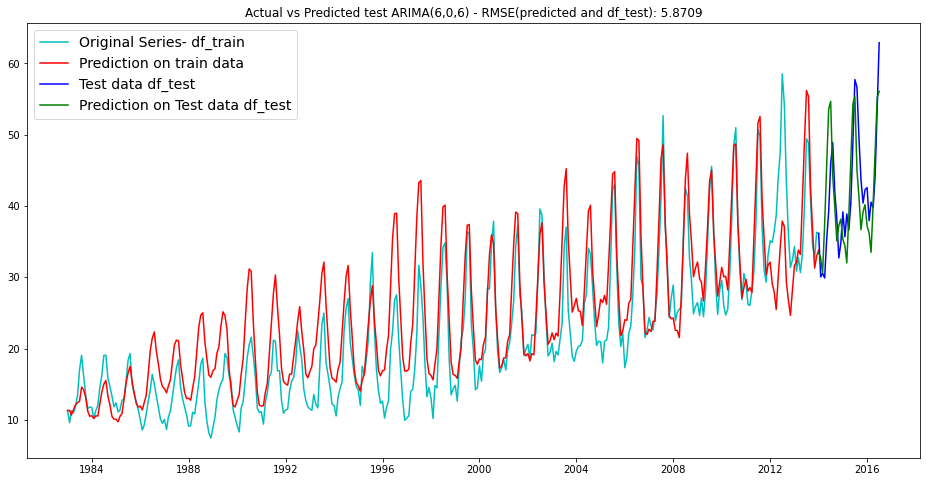

In [ ]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df_train, color = 'c', label = 'Original Series- df_train')
plt.plot(predictions_ARIMA, color = 'r', label = 'Prediction on train data') #plot the predictions ARIMA series
plt.plot(df_test, label = 'Test data df_test', color='b')  #plot the forecasted ARIMA series

plt.plot(forecasted_test_ARIMA, label = 'Prediction on Test data df_test', color='g')  #plot the forecasted ARIMA series

plt.title('Actual vs Predicted test ARIMA(6,0,6) - RMSE(predicted and df_test): %.4f'% mean_squared_error(forecasted_test_ARIMA,df_test['Value'], squared=False))  #Calculating rmse

plt.legend()
plt.show()

In [ ]:
print('The mean absolute percentage error (MAPE) is for the test data and forecasted test data is ',round(mape(df_test['Value'],forecasted_test_ARIMA),2))

The mean absolute percentage error (MAPE) is for the test data and forecasted test data is  11.58


# Forecasting beyond available data timeframe using ARIMA(6,0,6)

In [ ]:
#Forecasting the values using ARIMA(6,0,6) to the requested time frame 2016-07-01','2017-07-01
# will include first six months of the year 2016 

index_future = pd.date_range('2014-01-01','2017-08-01' , freq='1M')- pd.offsets.MonthBegin(1)
steps=index_future.shape[0]
forecasted_ARIMA2 =results_ARIMA.forecast(steps=steps)  #steps will be 43 for this date range
forecasted_cumsum2 =forecasted_ARIMA2[0].cumsum() # use cumsum fuction on the forecast to reverse differencing step 

#initialize with first data point from df_test for the initial date 2014-01-01. 
predictions_log = pd.Series(df_test_log['Value'].iloc[0], index=index_future)
predictions_log2= pd.Series(forecasted_cumsum2, index=index_future)
predictions_log_future = predictions_log.add(predictions_log2, fill_value=0)

In [ ]:
df_test_log.iloc[0]  #checking initial condition for forecast model - start forecast at beginning of cycle

Value    3.587207
Name: 2014-01-01 00:00:00, dtype: float64

In [ ]:
# create dataframe for future forecast 
df_future = pd.DataFrame()
df_future['future forecast'] = predictions_log_future 
df_future.index = index_future

In [ ]:
#Applying exponential transformation to the forecasted log values
future_forecast_ARIMA = np.exp(df_future['future forecast'] ) #use exponential function on forecasted data

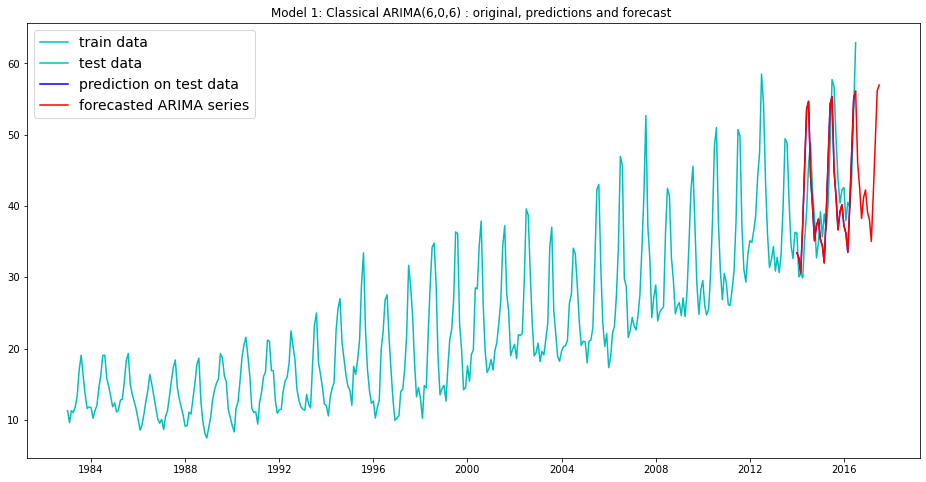

In [ ]:
#Plotting the original vs predicted and forecasted series
plt.figure(figsize=(16,8))
plt.plot(df_train, label = 'train data', color='c')  
plt.plot(df_test, label = 'test data', color='c')  
#plt.plot(predictions_ARIMA, label = 'Prediction on train data', color='b') 
plt.plot(forecasted_test_ARIMA, label = 'prediction on test data', color='b')  #plot the forecasted ARIMA series for test time 
plt.plot(future_forecast_ARIMA, color = 'r', label = 'forecasted ARIMA series') #plot the forecasted ARIMA series reaching 2017-07-01
plt.title('Model 1: Classical ARIMA(6,0,6) : original, predictions and forecast ')

plt.legend()
plt.show()

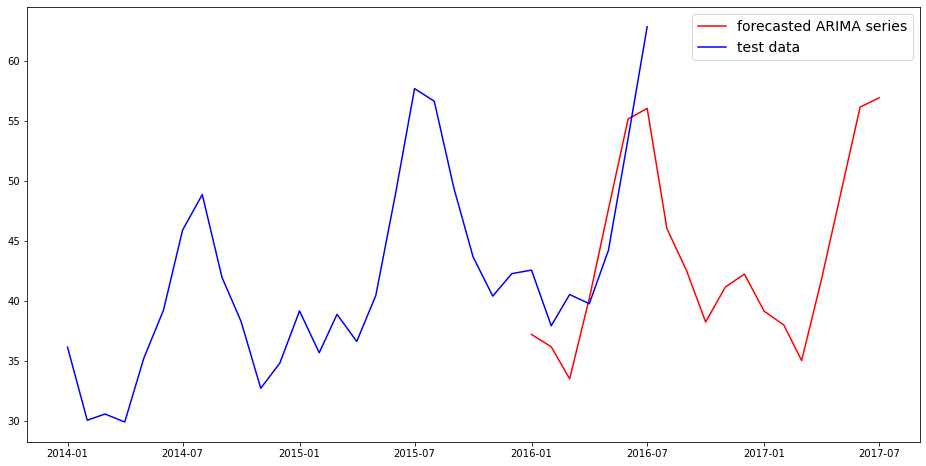

In [ ]:
# better view of forecast in comparison to test
plt.figure(figsize=(16,8))
future_forecast_ARIMA=future_forecast_ARIMA.loc['2016-01-01':'2017-07-01']
plt.plot(future_forecast_ARIMA, color = 'r', label = 'forecasted ARIMA series') #plot the forecasted ARIMA series
plt.plot(df_test, label = 'test data', color='b')  
plt.legend()
plt.show()

***Observation***
- Lower errors (rmse and MAPE) on train than on test may suggest potential overfitting.

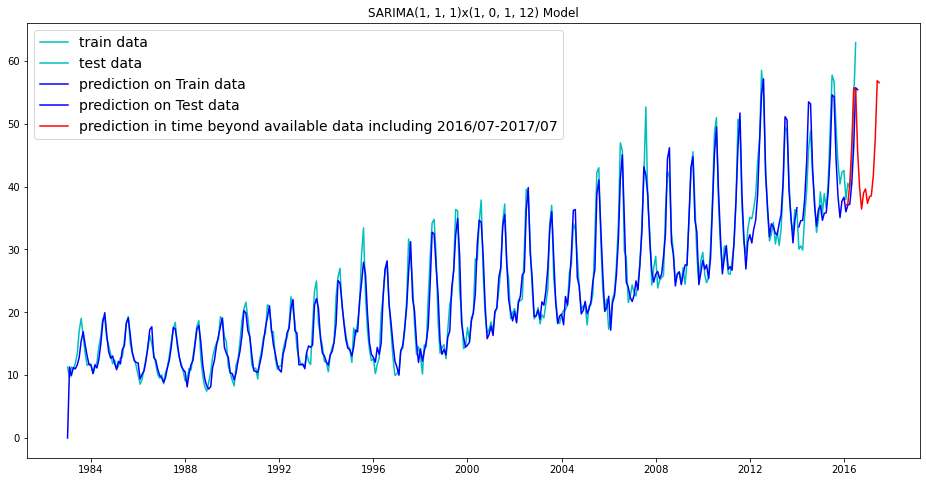

In [ ]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df_train, label = 'train data', color='c')  #plot the original series
plt.plot(df_test, label = 'test data', color='c')  #plot the original 
plt.plot(prediction_SA, color = 'b', label = 'prediction on Train data') #plot the predictions ARIMA series
plt.plot(forecasted_SA, color = 'b', label = 'prediction on Test data') #plot the predictions ARIMA series
plt.plot(df_future, color = 'r', label = 'prediction in time beyond available data including 2016/07-2017/07')

plt.title('SARIMA(1, 1, 1)x(1, 0, 1, 12) Model')

#plt.plot(forecasted_ARIMA, label = 'Prediction on Test data', color='g')  #plot the forecasted ARIMA series

plt.legend()
plt.show()

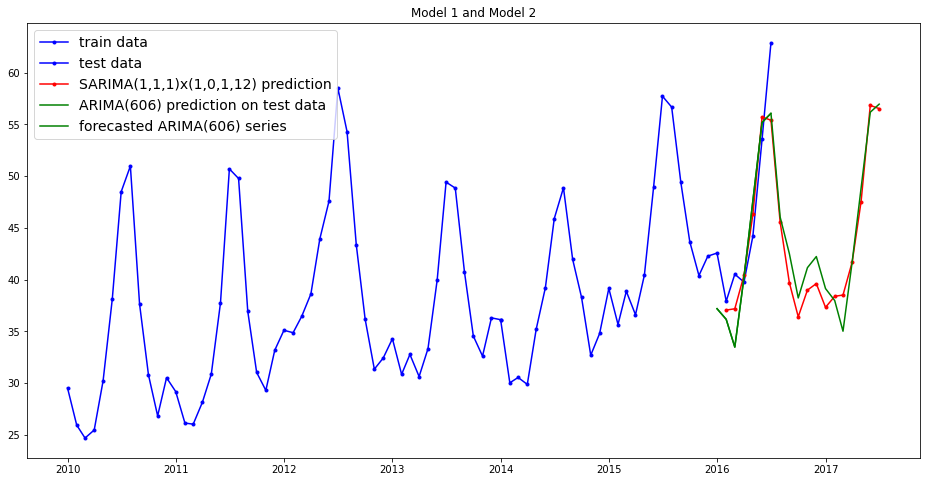

In [ ]:
# Compare both models in a plot with reduced time range
plt.figure(figsize=(16,8))
#plt.plot(future_forecast_ARIMA, color = 'r', label = 'forecasted ARIMA series') #plot the forecasted ARIMA series
plt.plot(df_train.loc['2010-01-01':'2017-07-01'], label = 'train data',marker='.', color='b')  
plt.plot(df_test, label = 'test data', color='b',marker='.')  
plt.plot(df_future, color = 'r',marker='.', label = 'SARIMA(1,1,1)x(1,0,1,12) prediction')
plt.plot(forecasted_test_ARIMA.loc['2016-01-01':'2017-07-01'], label = 'ARIMA(606) prediction on test data', color='g')  #plot the forecasted ARIMA series for test time 
plt.plot(future_forecast_ARIMA.loc['2016-01-01':'2017-07-01'], color = 'g', label = 'forecasted ARIMA(606) series') #plot the forecasted ARIMA series reaching 2017-07-01

plt.title('Model 1 and Model 2')

#plt.plot(forecasted_ARIMA, label = 'Prediction on Test data', color='g')  #plot the forecasted ARIMA series

plt.legend()
plt.show()

***Observation***
- Very similar forecast for ARIMA(6,0,6) and SARIMA(1,1,1)(1,0,1,12) for time period of : 2016-07-01 to 2017-07-01.